In [1]:
import cv2 as cv
import numpy as np
import torch
import message_filters
import rospy
import sys
import time

from sensor_msgs.msg import Image
from cv_bridge import CvBridge
from rospkg import RosPack # get abs path
from os import path # get home path
from gazebo_msgs.msg import ModelStates
from geometry_msgs.msg import *
from pyquaternion import Quaternion as PyQuaternion

In [2]:
# global variables
path_yolo = path.join("/home/user/workspace/UR5-Pick-and-Place-Simulation", 'yolov5')
path_vision = RosPack().get_path('vision')
path_weigths = path.join(path_vision, 'weigths')

cam_point = (-0.44, -0.5, 1.58)
height_tavolo = 0.74
dist_tavolo = None
origin = None
model = None
model_orientation = None
a_show = True

load models

In [53]:
torch.hub.load('ultralytics/yolov5', 'yolov5s')

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/ubuntu/.cache/torch/hub/master.zip


URLError: <urlopen error timed out>

In [3]:
# load models
print("Loading model best.pt")
# weight = path.join(path_weigths, 'best.pt')
weight = path.join(path_yolo, 'models/weights/yolov5s-cls.pt')
# model = torch.hub.load(path_yolo,'custom',path=weight, source='local')
model = torch.hub.load(path_yolo, 'yolov5s')

#yolo model and weights orientation
#print("Loading model orientation.pt")
#weight = path.join(path_weigths, 'depth.pt')
#model_orientation = torch.hub.load(path_yolo,'custom',path=weight, source='local')

Loading model best.pt


ValueError: too many values to unpack (expected 2)

get images from the camera

In [4]:
# init node
rospy.init_node('vision') 

In [5]:
rgb = None
depth = None

def get_image(image_rgb, image_depth):
    global rgb
    global depth
    
    #from standard message image to opencv image
    rgb = CvBridge().imgmsg_to_cv2(image_rgb, "bgr8")                                                
    depth = CvBridge().imgmsg_to_cv2(image_depth, "32FC1")
    
    rospy.signal_shutdown(0)

# original pictures 
raw_rgb = message_filters.Subscriber("/camera/color/image_raw", Image)
raw_depth = message_filters.Subscriber("/camera/depth/image_raw", Image)

#images synchronization
syncro = message_filters.TimeSynchronizer([raw_rgb, raw_depth], 1, reset=True)

# callback
syncro.registerCallback(get_image)
rospy.spin()


In [10]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

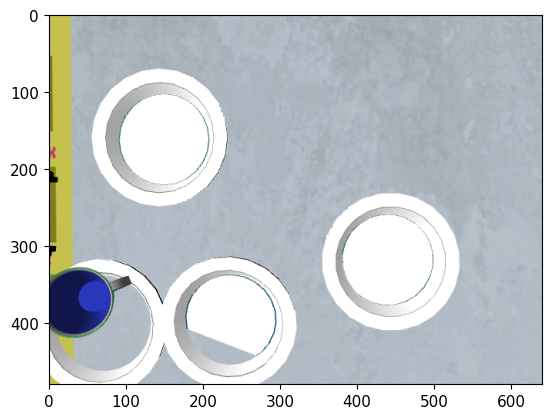

In [12]:
plt.imshow(rgb)
plt.show()

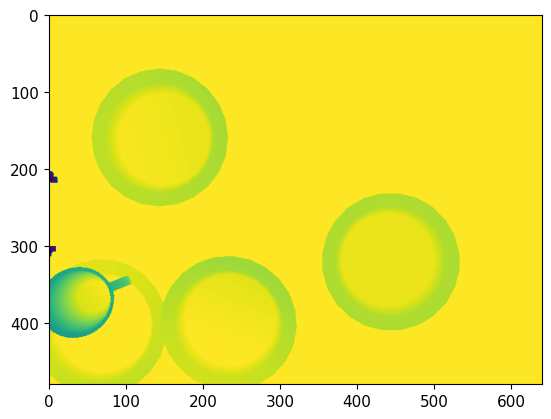

In [13]:
plt.imshow(depth)
plt.show()

process image with yolo

In [14]:

def get_dist_tavolo(depth, hsv, img_draw):
    """
    Get the distance of the table from the camera
    Args:
        depth (_type_): 
        hsv (_type_): 
        img_draw (_type_): 
    """
    global dist_tavolo

    #color = (120,1,190)
    #mask = get_dish_mask(color, hsv, (5, 5, 5))
    #dist_tavolo = depth[mask].max()
    #if dist_tavolo > 1: dist_tavolo -= height_tavolo
    dist_tavolo = np.nanmax(depth)
    
img_draw = rgb.copy()
hsv = cv.cvtColor(rgb, cv.COLOR_BGR2HSV)

get_dist_tavolo(depth, hsv, img_draw)


In [15]:
def get_origin(img):
    """
    Get the origin point of the image
    """
    global origin
    origin = np.array(img.shape[1::-1]) // 2
    
get_origin(rgb)
    

In [47]:
# yolo run 
import torch
model.conf = 0.6
model_input = torch.FloatTensor(rgb[np.newaxis, :].transpose((0,3,1,2)))
results = model(model_input)


In [50]:
results

tensor([[-2.06595e+01,  1.34215e+01, -6.21399e+01, -5.58666e+01, -2.66624e+01, -1.86748e+01, -2.63168e+00,  1.83027e-01,  4.12064e+01,  3.29964e+01, -3.57123e+01, -2.60872e+00, -3.16926e+00, -2.47506e+00, -4.58962e+01, -1.11185e+01,  9.91200e-01,  9.51650e-01,  1.14345e+01, -3.44690e+01, -3.60219e+01, -6.36913e+01,
         -6.93728e+01,  3.35152e+01, -1.35449e+00,  2.26886e+01,  2.44674e+01, -3.23385e-01, -3.29336e+01, -4.53690e+01,  1.38087e+01,  1.87647e+01,  3.15029e+01, -5.95482e+01,  2.70133e+00,  2.25429e+01,  3.64788e+01,  4.69931e+01, -6.76203e+01, -2.50053e+01,  3.51525e+01, -6.36483e+00, -1.43267e-01,  5.42157e+00,
         -4.93365e+01, -7.15294e+00,  4.05391e-01,  1.37105e+00, -2.99226e+01,  3.03151e+01,  5.14487e+00, -8.08743e+00, -1.41302e+01, -5.86967e+01, -2.67426e+01, -6.11225e+01, -4.78775e+01, -4.70370e+01, -7.45251e+00, -1.56082e+01, -1.55974e+01,  3.30581e+01, -2.46694e+01, -7.08788e+01,  5.39097e+01, -7.95078e+01,
          3.90346e+01,  1.23954e+01,  1.19924e+01

In [ ]:
pandino = results.pandas().xyxy[0].to_dict(orient="records")

In [23]:
results.print()

image 1/1: 480x640 2 X1-Y2-Z2-CHAMFERs, 1 X2-Y2-Z2-FILLET
Speed: 20.0ms pre-process, 140.3ms inference, 4.0ms NMS per image at shape (1, 3, 480, 640)


In [22]:
results.pandas()

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 480x640 2 X1-Y2-Z2-CHAMFERs, 1 X2-Y2-Z2-FILLET
Speed: 20.0ms pre-process, 140.3ms inference, 4.0ms NMS per image at shape (1, 3, 480, 640)

In [17]:
print(pandino)

[{'xmin': 209.6274871826172, 'ymin': 312.23565673828125, 'xmax': 278.4759521484375, 'ymax': 347.302001953125, 'confidence': 0.7928917407989502, 'class': 3, 'name': 'X1-Y2-Z2-CHAMFER'}, {'xmin': 6.125698089599609, 'ymin': 342.6791076660156, 'xmax': 83.6749267578125, 'ymax': 414.3938903808594, 'confidence': 0.6773579120635986, 'class': 10, 'name': 'X2-Y2-Z2-FILLET'}, {'xmin': 129.12403869628906, 'ymin': 72.94996643066406, 'xmax': 198.6393280029297, 'ymax': 119.93153381347656, 'confidence': 0.6004664897918701, 'class': 3, 'name': 'X1-Y2-Z2-CHAMFER'}]


In [18]:
if depth is None:
    print("No depth image received, You don't have to run the pandino nodes")

for process of the first pandino

In [19]:
# for process of the first pandino
item = pandino[0]
x1, y1, x2, y2, cn, cl, nm = item.values()
print(x1, y1, x2, y2, cn, cl, nm)

209.6274871826172 312.23565673828125 278.4759521484375 347.302001953125 0.7928917407989502 3 X1-Y2-Z2-CHAMFER


In [ ]:
# use mar=15 to avoid the error of the bounding box
mar = 15
x1, y1 = max(mar, x1), max(mar, y1)
x2, y2 = min(rgb.shape[1]-mar, x2), min(rgb.shape[0]-mar, y2)
boxMin = np.array((x1-mar, y1-mar))
x1, y1, x2, y2 = np.int0((x1, y1, x2, y2))
print(x1, y1, x2, y2, cn, cl, nm)

In [ ]:
def get_dish_color(center, rgb):
    """
    Get the color of the dish from the center of the image

    Args:
        center (_type_): _description_
        rgb (_type_): _description_

    Returns:
        _type_: _description_
    """
    return rgb[center].tolist()

boxCenter = (y2 + y1) // 2, (x2 + x1) // 2
color = get_dish_color(boxCenter, rgb)
hsvcolor = get_dish_color(boxCenter, hsv)

sliceBox = slice(y1-mar, y2+mar), slice(x1-mar, x2+mar)

#crop img with coordinate bounding box; computing all imgs
l_rgb = rgb[sliceBox]
l_hsv = hsv[sliceBox]

if a_show: 
    cv.rectangle(img_draw, (x1,y1),(x2,y2), color, 2)
    cv.imshow("img", img_draw)
    cv.waitKey(0)

From this part, the code is different:
- for the dish, the color would not be the same as lego
- so we need a model to predict the grasp point

In [ ]:
def get_dish_mask(color, hsv, toll = (20, 20, 255)):
    """
    Get the mask of the dish by the color - because the color of the dish is consistant and unique

    Args:
        color (_type_): _description_
        hsv (_type_): _description_
        toll (tuple, optional): _description_. Defaults to (20, 20, 255).

    Returns:
        _type_: _description_
    """
    thresh = np.array(color)
    mintoll = thresh - np.array([toll[0], toll[1], min(thresh[2]-1, toll[2])])
    maxtoll = thresh + np.array(toll)
    return cv.inRange(hsv, mintoll, maxtoll)

# get mask
l_depth = depth[sliceBox]
l_mask = get_dish_mask(hsvcolor, l_hsv) # filter mask by color


In [ ]:
# ----
if depth is not None:
    imgs = (rgb, hsv, depth, img_draw)
    for item in pandino[1:]:
        #obtaining Yolo informations (class, coordinates, center)
        x1, y1, x2, y2, cn, cl, nm = item.values()
        # use mar=15 to avoid the error of the bounding box
        mar = 15
        x1, y1 = max(mar, x1), max(mar, y1)
        x2, y2 = min(rgb.shape[1]-mar, x2), min(rgb.shape[0]-mar, y2)
        boxMin = np.array((x1-mar, y1-mar))
        x1, y1, x2, y2 = np.int0((x1, y1, x2, y2))
        
        boxCenter = (y2 + y1) // 2, (x2 + x1) // 2
        color = get_dish_color(boxCenter, rgb)
        hsvcolor = get_dish_color(boxCenter, hsv)
        
        sliceBox = slice(y1-mar, y2+mar), slice(x1-mar, x2+mar)

        #crop img with coordinate bounding box; computing all imgs
        l_rgb = rgb[sliceBox]
        l_hsv = hsv[sliceBox]

        if a_show: cv.rectangle(img_draw, (x1,y1),(x2,y2), color, 2)

        l_depth = depth[sliceBox]

        l_mask = get_dish_mask(hsvcolor, l_hsv) # filter mask by color
        l_mask = np.where(l_depth < dist_tavolo, l_mask, 0)

        l_depth = np.where(l_mask != 0, l_depth, dist_tavolo)



        # --------
        
        
        #myimshow("asda", hsv)
        #getting dish height from camera and table
        l_dist = get_dish_distance(l_depth)
        l_height = dist_tavolo - l_dist
        #masking 
        l_top_mask = cv.inRange(l_depth, l_dist-0.002, l_dist+0.002)
        #cv.bitwise_xor(img_draw,img_draw,img_draw, mask=cv.inRange(depth, l_dist-0.002, l_dist+0.002))
        #myimshow("hmask", l_top_mask)

        # model detect orientation
        depth_borded = np.zeros(depth.shape, dtype=np.float32)
        depth_borded[sliceBox] = l_depth

        depth_image = cv.normalize(
            depth_borded, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U
        )
        depth_image = cv.cvtColor(depth_image, cv.COLOR_GRAY2RGB).astype(np.uint8)
    
        #yolo in order to keep te orientation
        #print("Model orientation: Start...", end='\r')
        model_orientation.conf = 0.7
        results = model_orientation(depth_image)
        pandino = []
        pandino = results.pandas().xyxy[0].to_dict(orient="records")
        
        n = len(pandino)
        #print("Model orientation: Finish", n)
        
        
        # Adjust prediction
        pinN, ax, isCorrect = getDepthAxis(l_height, nm)
        if not isCorrect and ax == 2:
            if cl in (1,2,3) and pinN in (1, 2):    # X1-Y2-Z*, *1,2,2-CHAMFER
                cl = 1 if pinN == 1 else 2          # -> Z'pinN'
            elif cl in (7, 8) and pinN in (1, 2):   # X1-Y4-Z*, *1,2
                cl = 7 if pinN == 1 else 8          # -> Z'pinN'
            elif pinN == -1:
                nm = "{} -> {}".format(nm, "Target")
            else:
                print("[Warning] Error in classification")
        elif not isCorrect:
            ax = 1
            if cl in (0, 2, 5, 8) and pinN <= 4:    # X1-Y*-Z2, *1,2,3,4
                cl = (2, 5, 8)[pinN-2]              # -> Y'pinN'
            elif cl in (1, 7) and pinN in (2, 4):   # X1-Y*-Z1, *2,4
                cl = 1 if pinN == 2 else 7          # -> Y'pinN'
            elif cl == 9 and pinN == 1:     # X2-Y2-Z2
                cl = 2                      # -> X1
                ax = 0
            else: print("[Warning] Error in classification")
        nm = kitchenClasses[cl]

        if n != 1:
            print("[Warning] Classification not found")
            or_cn, or_cl, or_nm = ['?']*3
            or_nm = ('lato', 'lato', 'sopra/sotto')[ax]
        else:
            print()
            #obtaining Yolo informations (class, coordinates, center)
            or_item = pandino[0]
            or_cn, or_cl, or_nm = or_item['confidence'], or_item['class'], or_item['name']
            if or_nm == 'sotto': ax = 2 
            if or_nm == 'lato' and ax == 2: ax = 1
        #---



        #creating silouette top surface dish
        contours, hierarchy = cv.findContours(l_top_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        top_center = np.zeros(2)
        for cnt in contours:
            tmp_center, top_size, top_angle = cv.minAreaRect(cnt)
            top_center += np.array(tmp_center)
        top_center = boxMin + top_center / len(contours)
        #creating silouette dish
        contours, hierarchy = cv.findContours(l_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0: return None
        cnt = contours[0]
        l_center, l_size, l_angle = cv.minAreaRect(cnt)
        l_center += boxMin
        if ax != 2: l_angle = top_angle
        l_box = cv.boxPoints((l_center, l_size, l_angle))
        
        
        if l_size[0] <=3 or l_size[1] <=3:
            cv.drawContours(img_draw, np.int0([l_box]), 0, (0,0,0), 2)
            return None # filter out artifacts
        
        if a_show: cv.drawContours(img_draw, np.int0([l_box]), 0, color, 2)
        

        # silouette distorption
        # get vertexs distance from origin 
        top_box = l_box.copy()
        vertexs_norm = [(i, np.linalg.norm(vec - origin)) for vec, i in zip(l_box, range(4))]
        vertexs_norm.sort(key=lambda tup: tup[1])
        # get closest vertex to the image origin point
        iver = vertexs_norm[0][0]
        vec = l_box[iver]
        # distorping closest vertex (consider the distrotion by the height)
        if or_nm == 'sopra': l_height -= 0.019
        top_box[iver] = point_distorption(l_box[iver], l_height, origin)
        v0 = top_box[iver] - vec
        # adapt adiacents veretx
        v1 = l_box[iver - 3] - vec    # i - 3 = i+1 % 4
        v2 = l_box[iver - 1] - vec

        top_box[iver - 3] += np.dot(v0, v2) / np.dot(v2, v2) * v2
        top_box[iver - 1] += np.dot(v0, v1) / np.dot(v1, v1) * v1

        l_center = (top_box[0] + top_box[2]) / 2

        if a_show:
            cv.drawContours(img_draw, np.int0([top_box]), 0, (5,5,5), 2)
            cv.circle(img_draw, np.int0(top_box[iver]),1, (0,0,255),1,cv.LINE_AA)    



        #rotation and axis drawing
        if or_nm in ('sopra', 'sotto', 'sopra/sotto', '?'): # fin x, y directions (dirX, dirY)
            dirZ = np.array((0,0,1))
            if or_nm == 'sotto': dirZ = np.array((0,0,-1))
            
            projdir = l_center - top_center
            if np.linalg.norm(projdir) < l_size[0] / 10:
                dirY = top_box[0] - top_box[1]
                dirX = top_box[0] - top_box[-1]
                if np.linalg.norm(dirY) < np.linalg.norm(dirX): dirX, dirY = dirY, dirX
                projdir = dirY * np.dot(dirY, projdir)
            edgeFar = [ver for ver in top_box if np.dot(ver - l_center, projdir) >= 0][:2]
            dirY = (edgeFar[0] + edgeFar[1]) / 2 - l_center
            dirY /= np.linalg.norm(dirY)
            dirY = np.array((*dirY, 0))
            dirX = np.cross(dirZ, dirY)

        elif or_nm == "lato": # find pin direction (dirZ)
            edgePin = [ver for ver in top_box if np.dot(ver - l_center, l_center - top_center) >= 0][:2]
            
            dirZ = (edgePin[0] + edgePin[1]) / 2 - l_center
            dirZ /= np.linalg.norm(dirZ)
            dirZ = np.array((*dirZ, 0))
            
            if cl == 10:
                if top_size[1] > top_size[0]: top_size = top_size[::-1]
                if top_size[0] / top_size[1] < 1.7: ax = 0
            if ax == 0:
                vx,vy,x,y = cv.fitLine(cnt, cv.DIST_L2,0,0.01,0.01)
                dir = np.array((vx, vy))
                vertexs_distance = [abs(np.dot(ver - l_center, dir)) for ver in edgePin]
                iverFar = np.array(vertexs_distance).argmin()
                
                dirY = edgePin[iverFar] - edgePin[iverFar-1]
                dirY /= np.linalg.norm(dirY)
                dirY = np.array((*dirY, 0))
                dirX = np.cross(dirZ, dirY)
                if a_show: cv.circle(img_draw, np.int0(edgePin[iverFar]), 5, (70,10,50), 1)
                #cv.line(img_draw, np.int0(l_center), np.int0(l_center+np.array([int(vx*100),int(vy*100)])),(0,0,255), 3)
            if ax == 1:
                dirY = np.array((0,0,1))
                dirX = np.cross(dirZ, dirY)

            if a_show: cv.line(img_draw, *np.int0(edgePin), (255,255,0), 2)

        l_center = point_inverse_distortption(l_center, l_height)

        # post rotation extra
        theta = 0
        if cl == 1 and ax == 1: theta = 1.715224 - np.pi / 2
        if cl == 3 and or_nm == 'sotto': theta = 2.359515 - np.pi
        if cl == 4 and ax == 1: theta = 2.145295 - np.pi
        if cl == 6 and or_nm == 'sotto': theta = 2.645291 - np.pi
        if cl == 10 and or_nm == 'sotto': theta = 2.496793 - np.pi

        rotX = PyQuaternion(axis=dirX, angle=theta)
        dirY = rotX.rotate(dirY)
        dirZ = rotX.rotate(dirZ)

        if a_show:
            # draw frame
            lenFrame = 50
            unit_z = 0.031
            unit_x = 22 * 0.8039 / dist_tavolo
            x_to_z = lenFrame * unit_z/unit_x
            center = np.int0(l_center)

            origin_from_top = origin - l_center
        
            endX = point_distorption(lenFrame * dirX[:2], x_to_z * dirX[2], origin_from_top)
            frameX = (center, center + np.int0(endX))

            endY = point_distorption(lenFrame * dirY[:2], x_to_z * dirY[2], origin_from_top)
            frameY = (center, center + np.int0(endY))
            
            endZ = point_distorption(lenFrame * dirZ[:2], x_to_z * dirZ[2], origin_from_top)
            frameZ = (center, center + np.int0(endZ))
            
            cv.line(img_draw, *frameX, (0,0,255), 2)
            cv.line(img_draw, *frameY, (0,255,0), 2)
            cv.line(img_draw, *frameZ, (255,0,0), 2)
            # ---

            # draw text
            if or_cl != '?': or_cn = ['SIDE', 'UP', 'DOWN'][or_cl]
            text = "{} {:.2f} {}".format(nm, cn, or_cn)
            (text_width, text_height) = cv.getTextSize(text, cv.FONT_HERSHEY_DUPLEX, 0.4, 1)[0]
            text_offset_x = boxCenter[1] - text_width // 2
            text_offset_y = y1 - text_height
            box_coords = ((text_offset_x - 1, text_offset_y + 1), (text_offset_x + text_width + 1, text_offset_y - text_height - 1))
            cv.rectangle(img_draw, box_coords[0], box_coords[1], (210,210,10), cv.FILLED)
            cv.putText(img_draw, text, (text_offset_x, text_offset_y), cv.FONT_HERSHEY_DUPLEX, 0.4, (255, 255, 255), 1)

In [ ]:
# show
cv.imshow("vision-results.png", img_draw)
cv.waitKey()